# Predição da Probabilidade de Inadimplência

Após feito a análise e tratamento de dados, é preciso encontrar o melhor modelo para solucionar tal problema. Para isso, será feito uma busca de melhores parâmetros de modelo através de um **Grid Search com Validação Cruzada**. Isto é feito através da combinações de todos os parâmetros escolhidos e avaliados através de uma validação cruzada.

## Pacotes e Inicialização Importantes

In [43]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# usado para o valor float do Pandas ficar neste formato
pd.options.display.float_format = '{:,.2f}'.format

# Em busca do melhor modelo

O melhor modelo a ser encontrado será feito da seguinte forma: Será feito duas buscas diferentes de parâmetros. Uma através dos dados processados (**ver Notebook de Processamento de Dados**) e outra com os dados sem processamento (apenas com a inclusão de ZEROS nos valores faltantes).

Cada busca será feita através de Validações Cruzadas com *K-Fold* de 5, o que permite um treinamento com 80% dos dados e a validação com os 20% restantes. Os parâmetros serão os seguintes:

In [13]:
params = {
    'subsample': [0.6, 0.8, 1.0], # Proporção dos samples para treinamento
    'colsample_bytree': [0.6, 0.8, 1.0], # Proporção dos samples na criação de cada árvore
    'scale_pos_weight': [1, 6.66, 14, 93.34], # Balanceamento dos exemplos
    'booster': ['gbtree', 'gblinear', 'dart'], # Método de Booster utilizado
    'n_estimators': [10, 100, 250], # Quantos estimadores são utilizados para predição
}

Como análise de desempenho, será avaliado o *F1-Score*, *Precision* e *Recall*. Através destes resultados, será escolhido qual o melhor modelo para ser utilizado nos dados de **teste**. Os resultados finais serão adquiridos vendo o desempenho do modelo no dataset **dev** gerado anteriormente, através do `classification_report` e da sua matriz de confusão, que é definida na função abaixo:

In [45]:
import matplotlib.pyplot as plt
import seaborn as sns

def make_confusion_matrix(cf, group_names=None, categories='auto', count=True,
                          percent=True, cbar=True, xyticks=True, xyplotlabels=True,
                          sum_stats=True, figsize=None, cmap='Blues', title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAcurácia={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('Valor Real')
        plt.xlabel('Valor Predito' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

# Melhor Resultado com os Dados Tratados

A procura pelo melhor modelo utilizando dados tratados com os melhores métodos do Notebook de **Processamento de Dados**.

In [11]:
train = pd.read_csv('../data/processed/train_processed.csv', sep=',')

In [12]:
X_train = train.drop(columns=['inadimplente'])
y_train = train['inadimplente']

In [16]:
xgb = XGBClassifier(random_state=0)

# Organzia a busca através dos parâmetros anteriores.
# O melhor modelo será o que tiver o maior `F1-Score`
clf = GridSearchCV(xgb, params, n_jobs=-1, cv=5, refit='f1', 
                   scoring=['f1', 'precision', 'recall'], verbose=2)

In [17]:
# Faz a busca pelo melhor modelo
clf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 44.9min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 61.9min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'n_estimators': [10, 100, 250],
                         'scale_pos_weight': [1, 6.66, 14, 93.34],
                         'subsample': [0.6, 0.8, 1.0]},
             refit='f1', scoring=['f1', 'precision', 'recall'], verbose=2)

Com a busca completa, podemos avaliar os melhores resultados encontrados.

In [36]:
# Apenas colunas que interessam para uma melhor visualização
columns = ['params', 'param_n_estimators', 'mean_test_f1', 'std_test_f1',
           'mean_test_precision', 'std_test_precision',
           'mean_test_recall', 'std_test_recall'
          ]
results = pd.DataFrame(clf.cv_results_)[columns]
results = results.sort_values('mean_test_f1', ascending=False)

In [37]:
results.head(10)

,params,param_n_estimators,mean_test_f1,std_test_f1,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall
27,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",250,0.42,0.01,0.32,0.01,0.61,0.01
89,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",100,0.42,0.00,0.32,0.00,0.60,0.01
305,"{'booster': 'dart', 'colsample_bytree': 1.0, '...",100,0.42,0.00,0.32,0.00,0.60,0.01
3,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",10,0.42,0.01,0.34,0.01,0.56,0.02
221,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",10,0.42,0.01,0.34,0.01,0.55,0.02
269,"{'booster': 'dart', 'colsample_bytree': 0.8, '...",100,0.42,0.01,0.32,0.00,0.60,0.01
15,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",100,0.42,0.01,0.32,0.00,0.60,0.01
4,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",10,0.42,0.01,0.34,0.01,0.55,0.01
28,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",250,0.42,0.00,0.32,0.00,0.61,0.01
231,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",100,0.42,0.01,0.32,0.00,0.60,0.01


O melhor modelo encontrado teve o desempenho médio de 0.42 de *F1-Score*, 0.32 de *Precision* e 0.61 de *Recall*, e não tendo mais que 0.01 de desvio padrão em qualquer uma dessas métricas, o que parece ter um resultado "estável" nos 5 Folds.

Através da classe utilizando pelo Grid Search, podemos verificar o valor exato do melhor score (que foi utilizado o *F1-Score*).

In [39]:
clf.best_score_

0.41937633891586507

E tambéms os melhores parâmetros da busca.

In [34]:
clf.best_params_

{'booster': 'gbtree',
 'colsample_bytree': 0.6,
 'n_estimators': 250,
 'scale_pos_weight': 6.66,
 'subsample': 0.6}

E agora, podemos predizer os dados de validação (**dev**), para ver o seu resultado em exemplos nunca vistos.

In [40]:
dev = pd.read_csv('../data/processed/dev_processed.csv', sep=',')

In [41]:
X_dev = train.drop(columns=['inadimplente'])
y_dev = train['inadimplente']

              precision    recall  f1-score   support

           0       0.97      0.91      0.94     82135
           1       0.33      0.62      0.43      5865

    accuracy                           0.89     88000
   macro avg       0.65      0.77      0.69     88000
weighted avg       0.93      0.89      0.91     88000



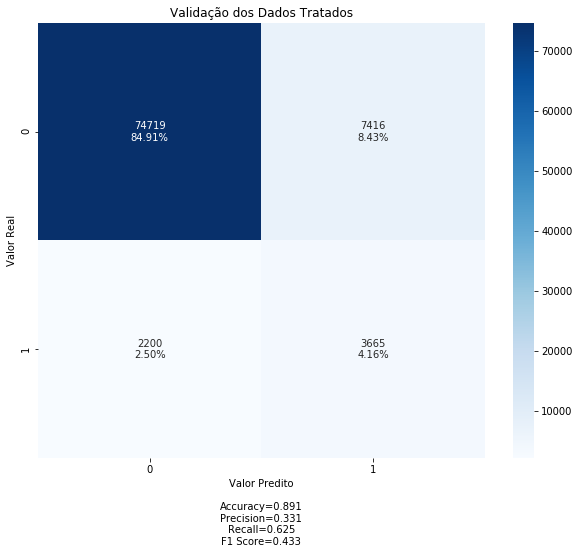

In [49]:
# Predição do melhor modelo
best_model_processed = clf.best_estimator_
y_pred = best_model_processed.predict(X_dev)

# Relatório de Classificação das Predições
print(classification_report(y_dev, y_pred))

# Matriz de Confusão das predições
cf = confusion_matrix(y_dev, y_pred)
make_confusion_matrix(cf, figsize=(10, 8), title='Validação dos Dados Tratados')

O modelo possuí uma baixa precisão nos dados positivos, o que faz ele acabar tendo mais erros do que acertos ao indicar um cliente **inadimplente**. Entretanto, ele possuí 0.625 de *Recall* na classe positiva e um bom *F1-Score* na classe negativa, o que acaba por ser um bom modelo para indicar clientes **não inadimplentes**, pois a sua confiabilidade neste classe é bem alta.

# Melhor Resultado com os Dados "Sem Processamento"

Agora, será feito o mesmo processo de busca nos dados que só tiveram os valores faltantes preenchidos com ZERO.

In [50]:
train = pd.read_csv('../data/processed/train.csv', sep=',')

In [51]:
X_train = train.drop(columns=['inadimplente'])
y_train = train['inadimplente']

In [52]:
xgb = XGBClassifier(random_state=0)
clf = GridSearchCV(xgb, params, n_jobs=-1, cv=5, refit='f1', 
                   scoring=['f1', 'precision', 'recall'], verbose=2)

In [53]:
clf.fit(X_train, y_train)

Fitting 5 folds for each of 324 candidates, totalling 1620 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 357 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 640 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1005 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 1450 tasks      | elapsed: 40.5min
[Parallel(n_jobs=-1)]: Done 1620 out of 1620 | elapsed: 56.2min finished


GridSearchCV(cv=5, estimator=XGBClassifier(), n_jobs=-1,
             param_grid={'booster': ['gbtree', 'gblinear', 'dart'],
                         'colsample_bytree': [0.6, 0.8, 1.0],
                         'n_estimators': [10, 100, 250],
                         'scale_pos_weight': [1, 6.66, 14, 93.34],
                         'subsample': [0.6, 0.8, 1.0]},
             refit='f1', scoring=['f1', 'precision', 'recall'], verbose=2)

Com a busca finalizada novamente, podemos verificar os novos resultados.

In [54]:
results2 = pd.DataFrame(clf.cv_results_)[columns]
results2 = results2.sort_values('mean_test_f1', ascending=False)

In [55]:
results2.head(10)

,params,param_n_estimators,mean_test_f1,std_test_f1,mean_test_precision,std_test_precision,mean_test_recall,std_test_recall
221,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",10,0.43,0.01,0.37,0.01,0.52,0.02
220,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",10,0.42,0.01,0.34,0.01,0.55,0.02
305,"{'booster': 'dart', 'colsample_bytree': 1.0, '...",100,0.42,0.00,0.33,0.00,0.59,0.01
89,"{'booster': 'gbtree', 'colsample_bytree': 1.0,...",100,0.42,0.00,0.33,0.00,0.59,0.01
232,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",100,0.42,0.01,0.32,0.00,0.60,0.01
219,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",10,0.42,0.01,0.34,0.00,0.54,0.02
17,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",100,0.42,0.01,0.33,0.01,0.59,0.01
15,"{'booster': 'gbtree', 'colsample_bytree': 0.6,...",100,0.42,0.01,0.32,0.00,0.60,0.02
233,"{'booster': 'dart', 'colsample_bytree': 0.6, '...",100,0.42,0.01,0.33,0.00,0.59,0.02
269,"{'booster': 'dart', 'colsample_bytree': 0.8, '...",100,0.42,0.01,0.33,0.00,0.59,0.01


In [59]:
clf.best_score_

0.43045382688749934

Os dados sem as etapas de processamento tiveram uma melhor precisão e *F1-Score* na etapa de busca do que os modelos anteriores. Veremos seu desempenho nos dados de validação.

In [60]:
clf.best_params_

{'booster': 'dart',
 'colsample_bytree': 0.6,
 'n_estimators': 10,
 'scale_pos_weight': 6.66,
 'subsample': 1.0}

In [56]:
dev = pd.read_csv('../data/processed/dev.csv', sep=',')

In [57]:
X_dev = train.drop(columns=['inadimplente'])
y_dev = train['inadimplente']

              precision    recall  f1-score   support

           0       0.97      0.93      0.95     82135
           1       0.36      0.53      0.43      5865

    accuracy                           0.91     88000
   macro avg       0.66      0.73      0.69     88000
weighted avg       0.93      0.91      0.91     88000



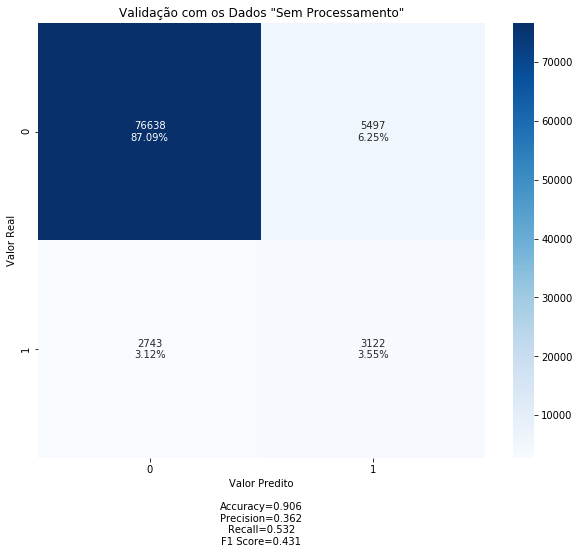

In [58]:
# Melhor modelo da busca 2
best_model_raw = clf.best_estimator_
y_pred = best_model_raw.predict(X_dev)

# Relatório de Classificação das Predições
print(classification_report(y_dev, y_pred))

# Matriz de Confusão das predições
cf = confusion_matrix(y_dev, y_pred)
make_confusion_matrix(cf, figsize=(10, 8), title='Validação com os Dados "Sem Processamento"')

Ambos modelos tiveram um desempenho próximo. Este aqui acaba saindo na frente nas métricas de acurácia e Precisão em comparação ao modelo anterior. **Entretanto**, o Recall do modelo anterior é maior, o que faz ele possuir um desempenho melhor na detecção de **não inadimplentes**. Ambos têm um baixa desempenho na detecção de **inadimplentes**, mas como o anterior acaba se saindo melhor na detecção oposta, ele será o escolhido como modelo final. Sendo assim, tal modelo poderia ser utilizado como um possível verificador de **não inadimplentes**, onde os que fossem detectados **inadimplentes** teriam que passar por uma análise mais a fundo.

# Usando o melhor modelo para predizer o arquivo `treino.csv`

E agora, será feito a predição do arquivo `treino.csv`, que não possuí a label **inadimplente**.

## Treinando o melhor modelo com TODOS os dados rotulados

Com o melhor modelo selecionado, podemos treinar o mesmo com todo os dados do arquivo `treino.csv`, para garantir que o mesmo tenha o melhor conhecimento para predições de novos dados.

In [61]:
# Arquivo com todos os dados de treino.csv processado
full_train = pd.read_csv('../data/processed/full_train_processed.csv', sep=',')

In [62]:
full_train

,util_linhas_inseguras_limitada,vezes_passou_de_30_59_dias,razao_debito_limitada,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,faixa_etaria,grupo_dependentes,grupo_salarial,inadimplente
0,0.12,0,0.29,20,0,2,0,7,2,3,0
1,1.00,0,0.28,3,0,1,0,5,0,3,0
2,0.23,0,0.39,12,0,1,0,7,3,3,0
3,1.00,0,0.37,4,0,1,0,9,1,3,0
4,0.02,0,2.00,4,0,1,0,9,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
109995,0.04,0,2.00,11,0,2,0,9,0,0,0
109996,0.00,0,0.52,13,0,2,0,9,1,3,0
109997,0.12,0,2.00,3,0,0,0,8,0,0,0
109998,0.09,0,0.29,5,0,2,0,10,0,2,0


In [63]:
X = full_train.drop(columns=['inadimplente'])
y = full_train['inadimplente']

In [64]:
best_model_processed.fit(X, y) # Treino com todos os dados

XGBClassifier(colsample_bytree=0.6, n_estimators=250, scale_pos_weight=6.66,
              subsample=0.6)

No notebook de **Processamento de Dados**, foi feito o tratamento dos dados de `teste.csv` com os mesmos métodos de `treino.csv`.

In [69]:
test = pd.read_csv('../data/processed/teste_processed.csv', sep=',')

In [70]:
test

,util_linhas_inseguras_limitada,vezes_passou_de_30_59_dias,razao_debito_limitada,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,faixa_etaria,grupo_dependentes,grupo_salarial
0,0.03,0,0.08,3,0,2,0,10,0,3
1,0.67,0,0.15,3,0,0,0,9,0,1
2,0.01,0,0.15,20,0,1,0,7,0,3
3,0.09,0,0.35,15,0,1,1,9,0,3
4,0.11,0,0.07,3,0,0,0,9,0,1
...,...,...,...,...,...,...,...,...,...,...
39995,0.00,1,0.06,9,1,0,0,10,0,3
39996,0.06,0,0.01,7,0,0,0,10,0,3
39997,0.82,0,0.66,17,0,2,0,10,0,3
39998,0.11,2,0.87,12,0,4,0,10,0,3


In [76]:
y_proba = best_model_processed.predict_proba(test) # Probabilidades das classes

In [79]:
y_proba[:, 1] # Retorna apenas a probabilidade da classe positiva

array([0.03276746, 0.20752178, 0.05286266, ..., 0.38787273, 0.60377026,
       0.8349377 ], dtype=float32)

In [82]:
test['inadimplente'] = y_proba[:, 1] # Adicionando a coluna inadimplente

In [83]:
test

,util_linhas_inseguras_limitada,vezes_passou_de_30_59_dias,razao_debito_limitada,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,faixa_etaria,grupo_dependentes,grupo_salarial,inadimplente
0,0.03,0,0.08,3,0,2,0,10,0,3,0.03
1,0.67,0,0.15,3,0,0,0,9,0,1,0.21
2,0.01,0,0.15,20,0,1,0,7,0,3,0.05
3,0.09,0,0.35,15,0,1,1,9,0,3,0.39
4,0.11,0,0.07,3,0,0,0,9,0,1,0.06
...,...,...,...,...,...,...,...,...,...,...,...
39995,0.00,1,0.06,9,1,0,0,10,0,3,0.64
39996,0.06,0,0.01,7,0,0,0,10,0,3,0.03
39997,0.82,0,0.66,17,0,2,0,10,0,3,0.39
39998,0.11,2,0.87,12,0,4,0,10,0,3,0.60


Salvando o arquivo com o nome `teste_processado.csv`

In [84]:
test.to_csv('../data/final/teste_processado.csv', sep=',', index=False)

## Adicionando o resultado no arquivo com o formato original

Agora que os dados do teste (com processamento) foram salvados, iremos pegar a mesma coluna de probabilidades e adicionarem nos dados originais de teste.csv, para ter os dois formatos disponíveis.

In [85]:
teste = pd.read_csv('../data/raw/teste.csv') # dado original (sem mudanças)

In [86]:
teste

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes
0,0.03,62,0,0.08,"8,180.00",3,0,2,0,0.00
1,0.67,55,0,0.15,"2,200.00",3,0,0,0,0.00
2,0.01,44,0,0.15,"7,499.00",20,0,1,0,0.00
3,0.09,54,0,0.35,"5,900.00",15,0,1,1,0.00
4,0.11,54,0,0.07,"2,167.00",3,0,0,0,0.00
...,...,...,...,...,...,...,...,...,...,...
39995,0.00,68,1,0.06,"10,833.00",9,1,0,0,0.00
39996,0.06,84,0,0.01,"8,456.00",7,0,0,0,0.00
39997,0.82,70,0,0.66,"6,000.00",17,0,2,0,0.00
39998,0.11,64,2,0.87,"5,045.00",12,0,4,0,0.00


In [87]:
teste['inadimplente'] = y_proba[:, 1] # adição das probabilidades

In [88]:
teste

,util_linhas_inseguras,idade,vezes_passou_de_30_59_dias,razao_debito,salario_mensal,numero_linhas_crdto_aberto,numero_vezes_passou_90_dias,numero_emprestimos_imobiliarios,numero_de_vezes_que_passou_60_89_dias,numero_de_dependentes,inadimplente
0,0.03,62,0,0.08,"8,180.00",3,0,2,0,0.00,0.03
1,0.67,55,0,0.15,"2,200.00",3,0,0,0,0.00,0.21
2,0.01,44,0,0.15,"7,499.00",20,0,1,0,0.00,0.05
3,0.09,54,0,0.35,"5,900.00",15,0,1,1,0.00,0.39
4,0.11,54,0,0.07,"2,167.00",3,0,0,0,0.00,0.06
...,...,...,...,...,...,...,...,...,...,...,...
39995,0.00,68,1,0.06,"10,833.00",9,1,0,0,0.00,0.64
39996,0.06,84,0,0.01,"8,456.00",7,0,0,0,0.00,0.03
39997,0.82,70,0,0.66,"6,000.00",17,0,2,0,0.00,0.39
39998,0.11,64,2,0.87,"5,045.00",12,0,4,0,0.00,0.60


Salvando o arquivo com o nome de `teste_formato_original.csv`

In [89]:
teste.to_csv('../data/final/teste_formato_original.csv', sep=',', index=False)